# Visualise KEGG Pathways with Custom Colours
The goal is to colour nodes from BETS output with different colours in the KEGG pathway. Code adapted from [here](https://nbviewer.jupyter.org/github/widdowquinn/notebooks/blob/master/Biopython_KGML_intro.ipynb). 

In [1]:
from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from Bio.Graphics.ColorSpiral import ColorSpiral

from IPython.display import Image, HTML, IFrame

import random
import pandas as pd
import networkx as nx
import seaborn as sns
import re
import os
sns.set()

Let us check the MAPK Signalling Pathway first. With `Bio.KEGG`, we can display it as an image.

## Read in BETS
Let us read in BETS graph and find nodes common with the MAPK Signalling pathway.

In [2]:
gene_details = pd.read_csv('../../../data/gene_details.csv', index_col=0)
results_file = '/mnt_volume/BETS/runs/arid_th1-0mean-reps-er-norm-enet-2-g/run_l-fdr/networks/arid_th1-0mean-reps-er-norm-enet-2-g-1-fdr-0.05-effect-matrix.txt'

bets_graph = pd.read_csv(results_file, sep='\t', index_col=0)
node_names = list(bets_graph.columns)

bets_graph = nx.from_numpy_matrix(bets_graph.to_numpy(), create_using=nx.DiGraph())

mapping = {}
for i in range(len(node_names)):
    try:
        entrez_name = 'mmu:' + str(int(gene_details.loc[node_names[i]].entrez))
    except ValueError: #nan
        entrez_name = node_names[i]
    mapping[i] = entrez_name

bets_graph = nx.relabel_nodes(bets_graph, mapping)

## Get KEGG Pathway information

In [35]:
pathway = KGML_parser.read(kegg_get("mmu04010", "kgml"))
print(pathway)

Pathway: MAPK signaling pathway
KEGG ID: path:mmu04010
Image file: http://www.kegg.jp/kegg/pathway/mmu/mmu04010.png
Organism: mmu
Entries: 132
Entry types:
	gene: 119
	group: 1
	compound: 5
	map: 7



In [39]:
pathway.genes[1].name

'mmu:13537 mmu:18218 mmu:19252 mmu:235584 mmu:240672 mmu:319520 mmu:63953 mmu:67603 mmu:70686 mmu:75590'

### Potential Problem

Notice that one gene can have more than one Entrez IDs associated with it. This is a problem because in the BETS graph, each gene is uniquely associated with an Entrez ID. In this scenario, more than one vertex in the BETS graph can be associated with one gene in the KEGG Pathway. 

This can happen - In the BETS graph, we can have 
$$ G_1 \rightarrow G_2 \rightarrow G_3 $$
but in the KEGG Pathway, $G_1$, $G_2$ and $G_3$ can map to the same gene.

For a given gene from BETS, it's descendants may map to the same gene in the KEGG Pathway.

#### Colour Palette
Choose Pastel Colour Palette from Seaborn

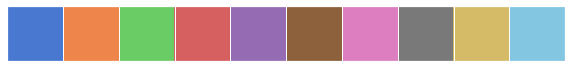

In [3]:
current_palette = sns.color_palette('muted').as_hex()
sns.palplot(current_palette)

### Generate new graph for each of these nodes with different color for anscenstor and descendants.

In [4]:
pathway_stats_less = pd.read_csv('/mnt_volume/static/pathway_statistics_less.csv', index_col=0)
lesser_pathways = list(pathway_stats_less[pathway_stats_less['p.val'] < 0.05]['id'])

pathway_stats_greater = pd.read_csv('/mnt_volume/static/pathway_statistics_greater.csv', index_col=0)
greater_pathways = list(pathway_stats_greater[pathway_stats_greater['p.val'] < 0.05]['id'])

all_pathways = lesser_pathways + greater_pathways

In [5]:
len(greater_pathways), len(lesser_pathways), len(all_pathways)

(14, 73, 87)

In [6]:
def get_bets_graph():
    gene_details = pd.read_csv('/mnt_volume/tt-atac-causal/data/gene_details.csv', index_col=0)
    results_file = '/mnt_volume/BETS/runs/arid_th1-0mean-reps-er-norm-enet-2-g/run_l-fdr/networks/arid_th1-0mean-reps' \
                   '-er-norm-enet-2-g-1-fdr-0.05-effect-matrix.txt '

    bets_graph = pd.read_csv(results_file, sep='\t', index_col=0)
    node_names = list(bets_graph.columns)

    bets_graph = nx.from_numpy_matrix(bets_graph.to_numpy(), create_using=nx.DiGraph())

    mapping = {}
    for i in range(len(node_names)):
        try:
            entrez_name = 'mmu:' + str(int(gene_details.loc[node_names[i]].entrez))
        except ValueError:  # nan
            entrez_name = node_names[i]
        mapping[i] = entrez_name

    bets_graph = nx.relabel_nodes(bets_graph, mapping)
    return bets_graph


def draw_bets_kegg_intersection(pathway, pathway_name):
    common_nodes_in_bets = []
    for gene in pathway.genes:
        names = gene.name.split(' ')
        for name in names:
            if name in bets_graph.nodes():
                colour = current_palette[0]
                if bets_graph.in_degree(name) == 0 and bets_graph.out_degree(name) != 0:
                    colour = current_palette[2]
                    print(name)
                common_nodes_in_bets.append(name)
                for graphic in gene.graphics:
                    graphic.bgcolor = colour
            else:
                for graphic in gene.graphics:
                    graphic.bgcolor = '#FFFFFF'
    
    # write to file
    write_directory = os.path.join('/mnt_volume/static/', pathway_name)
    if not os.path.exists(write_directory):
        os.makedirs(write_directory)

    filename = os.path.join(write_directory, pathway_name + ".pdf")
    canvas = KGMLCanvas(pathway, import_imagemap=True)
    canvas.draw(filename)
    return common_nodes_in_bets


def get_descendants(common_nodes_in_bets):
    genes_descendants = {}
    for node in common_nodes_in_bets:
        descendants = set(nx.descendants(bets_graph, node)) - {node} # remove self loops
        common = descendants.intersection(set(common_nodes_in_bets))
        if len(common) != 0:
            print('\n************\n' + node)
            print(common)
            genes_descendants[node] = common
    return genes_descendants


def write_to_file(pathway, gene_name, genes_descendants, pathway_name):
    # make everything white
    for gene in pathway.genes:
        for graphic in gene.graphics:
            graphic.bgcolor = '#FFFFFF'

    for gene in pathway.genes:
        names = gene.name.split(' ')
        for name in names:
            if name == gene_name:
                colour = current_palette[0]
                if bets_graph.in_degree(name) == 0 and bets_graph.out_degree(name) != 0:
                    colour = current_palette[2]
                for graphic in gene.graphics:
                    graphic.bgcolor = colour
            elif name in genes_descendants[gene_name]:
                for graphic in gene.graphics:
                    graphic.bgcolor = current_palette[-2]
            else:
                pass

    # write to file
    write_directory = os.path.join('/mnt_volume/static/', pathway_name)
    if not os.path.exists(write_directory):
        os.makedirs(write_directory)

    filename = os.path.join(write_directory, pathway_name + '_' + gene_name + ".pdf")

    canvas = KGMLCanvas(pathway, import_imagemap=True)
    canvas.draw(filename)


def get_pathway_per_gene_anscestor(kegg_pathway_code, pathway_name):
    pathway = KGML_parser.read(kegg_get(kegg_pathway_code, "kgml"))

    common_nodes_in_bets = draw_bets_kegg_intersection(pathway, pathway_name)

    genes_descendants = get_descendants(common_nodes_in_bets)

    for gene_name in genes_descendants:
        for gene in pathway.genes:
            names = gene.name.split(' ')
            for name in names:
                if name == gene_name:
                    temp = set(gene.name.split(' '))
                    break
        print('Intersection', genes_descendants[gene_name].intersection(temp))
        genes_descendants[gene_name] = genes_descendants[gene_name] - temp

        write_to_file(pathway, gene_name, genes_descendants, pathway_name)

In [ ]:
# generate for all significant pathways
all_pathways

for path in all_pathways:
    temp = path.split()
    code = temp[0]
    temp = [re.sub(r'\W+', '', _).lower() for _ in temp[1:]]
    name = '-'.join(temp)
    
    print('\n###########\nRunning for', name)
    get_pathway_per_gene_anscestor(code, name)


###########
Running for systemic-lupus-erythematosus
mmu:26914
mmu:319163
mmu:319177
mmu:319187
mmu:319190
mmu:78303
mmu:319150
mmu:319152
mmu:97114
mmu:319159
mmu:326620
mmu:97122

************
mmu:97114
{'mmu:382523'}
Intersection {'mmu:382523'}

###########
Running for ribosome

###########
Running for oxidative-phosphorylation
mmu:407790
mmu:407790
mmu:407790

###########
Running for glycolysis--gluconeogenesis
mmu:16828
mmu:74551

************
mmu:56421
{'mmu:68738'}
Intersection set()

###########
Running for parkinsons-disease
mmu:407790

###########
Running for huntingtons-disease
mmu:407790
mmu:21817
mmu:208647
mmu:52639
mmu:12287

************
mmu:21817
{'mmu:78330'}

************
mmu:52639
{'mmu:67530'}
Intersection set()
Intersection set()

###########
Running for alzheimers-disease
mmu:11820
mmu:407790
mmu:26417
mmu:16956
mmu:52639
mmu:11911
mmu:26417

************
mmu:11820
{'mmu:67530', 'mmu:22147'}

************
mmu:14812
{'mmu:16439'}

************
mmu:52639
{'mmu:675

### MAPK and BETS
Let us colour all nodes in common with BETS in a different colour.

In [7]:
common_nodes_in_bets = []
for gene in pathway.genes:
    names = gene.name.split(' ')
    for name in names:
        if name in bets_graph.nodes():
            common_nodes_in_bets.append(name)
            for graphic in gene.graphics:
                graphic.bgcolor = current_palette[1]
        else:
            for graphic in gene.graphics:
                graphic.bgcolor = '#FFFFFF'

canvas = KGMLCanvas(pathway, import_imagemap=True)
canvas.draw("mapk_bets.pdf")

### Descendant Relationship in BETS
Check if any common nodes are descendants of each other.

In [40]:
genes_descendants = {}
for node in common_nodes_in_bets:
    descendants = set(nx.descendants(bets_graph, node))
    common = descendants.intersection(set(common_nodes_in_bets))
    if len(common)!=0:
        print('\n************\n'+node)
        print(common)
        genes_descendants[node] = common


************
mmu:20663
{'mmu:26408'}

************
mmu:16590
{'mmu:14184', 'mmu:14171', 'mmu:18212', 'mmu:17869', 'mmu:14164', 'mmu:12292'}

************
mmu:21687
{'mmu:14184', 'mmu:14171', 'mmu:18212', 'mmu:17869', 'mmu:14164'}

************
mmu:23797
{'mmu:14171'}

************
mmu:17869
{'mmu:18212'}


## List of Interesting Pathways
Orange is the parent, and blue is the descendants.

1. MAPK - https://129.70.51.142:5000/mapk-signaling-pathway/mapk-signaling-pathway_mmu%3A17869.pdf
1. MAPK - https://129.70.51.142:5000/mapk-signaling-pathway/mapk-signaling-pathway_mmu%3A21687.pdf
1. Amoebiasis - https://129.70.51.142:5000/amoebiasis/amoebiasis_mmu%3A16772.pdf
1. Huntington's diesease - https://129.70.51.142:5000/huntingtons-disease/huntingtons-disease_mmu%3A21817.pdf
1. Alzheimer's disease - https://129.70.51.142:5000/alzheimers-disease/alzheimers-disease_mmu%3A11820.pdf
1. Alzheimer's disease - https://129.70.51.142:5000/alzheimers-disease/alzheimers-disease_mmu%3A14812.pdf
1. Arginine and proline metabolism - https://129.70.51.142:5000/arginine-and-proline-metabolism/arginine-and-proline-metabolism_mmu%3A12716.pdf
1. Bile secretion (interesting) - https://129.70.51.142:5000/bile-secretion/bile-secretion_mmu%3A11931.pdf

----------------

In [44]:
genes_descendants

{'mmu:20663': {'mmu:26408'},
 'mmu:16590': {'mmu:12292', 'mmu:14164', 'mmu:14171', 'mmu:17869'},
 'mmu:21687': {'mmu:14164', 'mmu:14171', 'mmu:17869'},
 'mmu:23797': {'mmu:14171'},
 'mmu:17869': {'mmu:18212'}}

In [42]:
gene_name = 'mmu:16590'

for gene in pathway.genes:
    names = gene.name.split(' ')
    for name in names:
        if name == gene_name:
            temp = set(gene.name.split(' '))
            break

print('Intersection', genes_descendants[gene_name].intersection(temp))
genes_descendants[gene_name] = genes_descendants[gene_name] - temp

Intersection {'mmu:18212', 'mmu:14184'}


##### Contradiction
We have a problem here. The current gene (`mmu:16590`) has many different names associated with it. Some of the names associated with it are listed as descendants in the BETS graph.

HACK - for now, remove the descendants which are also other names for the same gene.

In [43]:
gene_name = 'mmu:16590'
print('Descendants', genes_descendants[gene_name])

# make everything white
for gene in pathway.genes:
    for graphic in gene.graphics:
        graphic.bgcolor = '#FFFFFF'

for gene in pathway.genes:
    names = gene.name.split(' ')
    for name in names:
        if name == gene_name:
            for graphic in gene.graphics:
                graphic.bgcolor = current_palette[1]
        elif name in genes_descendants[gene_name]:
            for graphic in gene.graphics:
                graphic.bgcolor = current_palette[0]
        else:
            pass

Descendants {'mmu:17869', 'mmu:14164', 'mmu:12292', 'mmu:14171'}


In [33]:
canvas = KGMLCanvas(pathway, import_imagemap=True)
canvas.draw("mapk_bets_"+gene_name+".pdf")

In [37]:
gene_name = 'mmu:21687'

for gene in pathway.genes:
    names = gene.name.split(' ')
    for name in names:
        if name == gene_name:
            temp = set(gene.name.split(' '))
            break

print('Intersection', genes_descendants[gene_name].intersection(temp))
genes_descendants[gene_name] = genes_descendants[gene_name] - temp

Intersection {'mmu:18212', 'mmu:14184'}


In [38]:
gene_name = 'mmu:21687'
print(genes_descendants[gene_name])

# make everything white
for gene in pathway.genes:
    for graphic in gene.graphics:
        graphic.bgcolor = '#FFFFFF'

for gene in pathway.genes:
    names = gene.name.split(' ')
    for name in names:
        if name == gene_name:
            for graphic in gene.graphics:
                graphic.bgcolor = current_palette[1]
        elif name in genes_descendants[gene_name]:
            for graphic in gene.graphics:
                graphic.bgcolor = current_palette[0]
        else:
            pass
        
# write to file
canvas = KGMLCanvas(pathway, import_imagemap=True)
canvas.draw("mapk_bets_"+gene_name+".pdf")

{'mmu:17869', 'mmu:14164', 'mmu:14171'}


------------

In [8]:
# Kyoto Encyclopedia of Genes and Genomes
print(kegg_info("kegg").read())

kegg             Kyoto Encyclopedia of Genes and Genomes
kegg             Release 94.0+/04-16, Apr 20
                 Kanehisa Laboratories
                 pathway     701,754 entries
                 brite       246,899 entries
                 module          463 entries
                 orthology    23,318 entries
                 genome        6,830 entries
                 genes     31,407,917 entries
                 compound     18,699 entries
                 glycan       11,039 entries
                 reaction     11,414 entries
                 rclass        3,165 entries
                 enzyme        7,736 entries
                 network       1,125 entries
                 variant         416 entries
                 disease       2,417 entries
                 drug         11,255 entries
                 dgroup        2,276 entries
                 environ         864 entries



In [10]:
head(kegg_list('pathway', 'mmu').read())

path:mmu00010	Glycolysis / Gluconeogenesis - Mus musculus (mouse)
path:mmu00020	Citrate cycle (TCA cycle) - Mus musculus (mouse)
path:mmu00030	Pentose phosphate pathway - Mus musculus (mouse)
path:mmu00040	Pentose and glucuronate interconversions - Mus musculus (mouse)
path:mmu00051	Fructose and mannose metabolism - Mus musculus (mouse)
path:mmu00052	Galactose metabolism - Mus musculus (mouse)
path:mmu00053	Ascorbate and aldarate metabolism - Mus musculus (mouse)
path:mmu00061	Fatty acid biosynthesis - Mus musculus (mouse)
path:mmu00062	Fatty acid elongation - Mus musculus (mouse)
path:mmu00071	Fatty acid degradation - Mus musculus (mouse)
[...]


In [12]:
head(kegg_get("path:mmu00010").read())

ENTRY       mmu00010                    Pathway
NAME        Glycolysis / Gluconeogenesis - Mus musculus (mouse)
DESCRIPTION Glycolysis is the process of converting glucose into pyruvate and generating small amounts of ATP (energy) and NADH (reducing power). It is a central pathway that produces important precursor metabolites: six-carbon compounds of glucose-6P and fructose-6P and three-carbon compounds of glycerone-P, glyceraldehyde-3P, glycerate-3P, phosphoenolpyruvate, and pyruvate [MD:M00001]. Acetyl-CoA, another important precursor metabolite, is produced by oxidative decarboxylation of pyruvate [MD:M00307]. When the enzyme genes of this pathway are examined in completely sequenced genomes, the reaction steps of three-carbon compounds from glycerone-P to pyruvate form a conserved core module [MD:M00002], which is found in almost all organisms and which sometimes contains operon structures in bacterial genomes. Gluconeogenesis is a synthesis pathway of glucose from noncarbohydrate 

In [28]:
canvas = KGMLCanvas(pathway)
canvas.draw("fab_map.pdf")

In [29]:
canvas.import_imagemap = True
canvas.draw("fab_map_with_image.pdf")

In [30]:
def draw_kegg_map(map_id):
    """ Render a local PDF of a KEGG map with the passed map ID
    """
    # Get the background image first
    pathway = KGML_parser.read(kegg_get(map_id, "kgml"))
    canvas = KGMLCanvas(pathway, import_imagemap=True)
    img_filename = "%s.pdf" % map_id
    canvas.draw(img_filename)

In [38]:
print(pathway.genes[0].graphics[0].name)

Rasgrf1, AI844718, CDC25, CDC25Mm, Gnrp, Grf1, Grfbeta, P190-A, Ras-GRF1, p190, p190RhoGEF...


In [49]:
element = pathway.genes[0].graphics[0]
attrs = [element.name, element.x, element.y, element.coords, element.type, 
         element.width, element.height, element.fgcolor, element.bgcolor, 
         element.bounds, element.centre]
print('\n'.join([str(attr) for attr in attrs]))

Rasgrf1, AI844718, CDC25, CDC25Mm, Gnrp, Grf1, Grfbeta, P190-A, Ras-GRF1, p190, p190RhoGEF...
392.0
236.0
None
rectangle
46.0
17.0
#000000
#BFFFBF
[(369.0, 227.5), (415.0, 244.5)]
(392.0, 236.0)


In [50]:
# Helper function to convert colour as RGB tuple to hex string
def rgb_to_hex(rgb):
    rgb = tuple([int(255*val) for val in rgb])
    return '#' + ''.join([hex(val)[2:] for val in rgb]).upper()

In [52]:
# Define arbitrary colours
colorspiral = ColorSpiral()
colorlist = colorspiral.get_colors(len(pathway.genes))

# Change the colours of ortholog elements
for color, element in zip(colorlist, pathway.genes):
    for graphic in element.graphics:
        graphic.bgcolor = rgb_to_hex(color)

In [54]:
canvas = KGMLCanvas(pathway, import_imagemap=True)
canvas.draw("fab_map_new_colours.pdf")
PDF("./fab_map_new_colours.pdf")

In [72]:
current_palette[0]

'#a1c9f4'

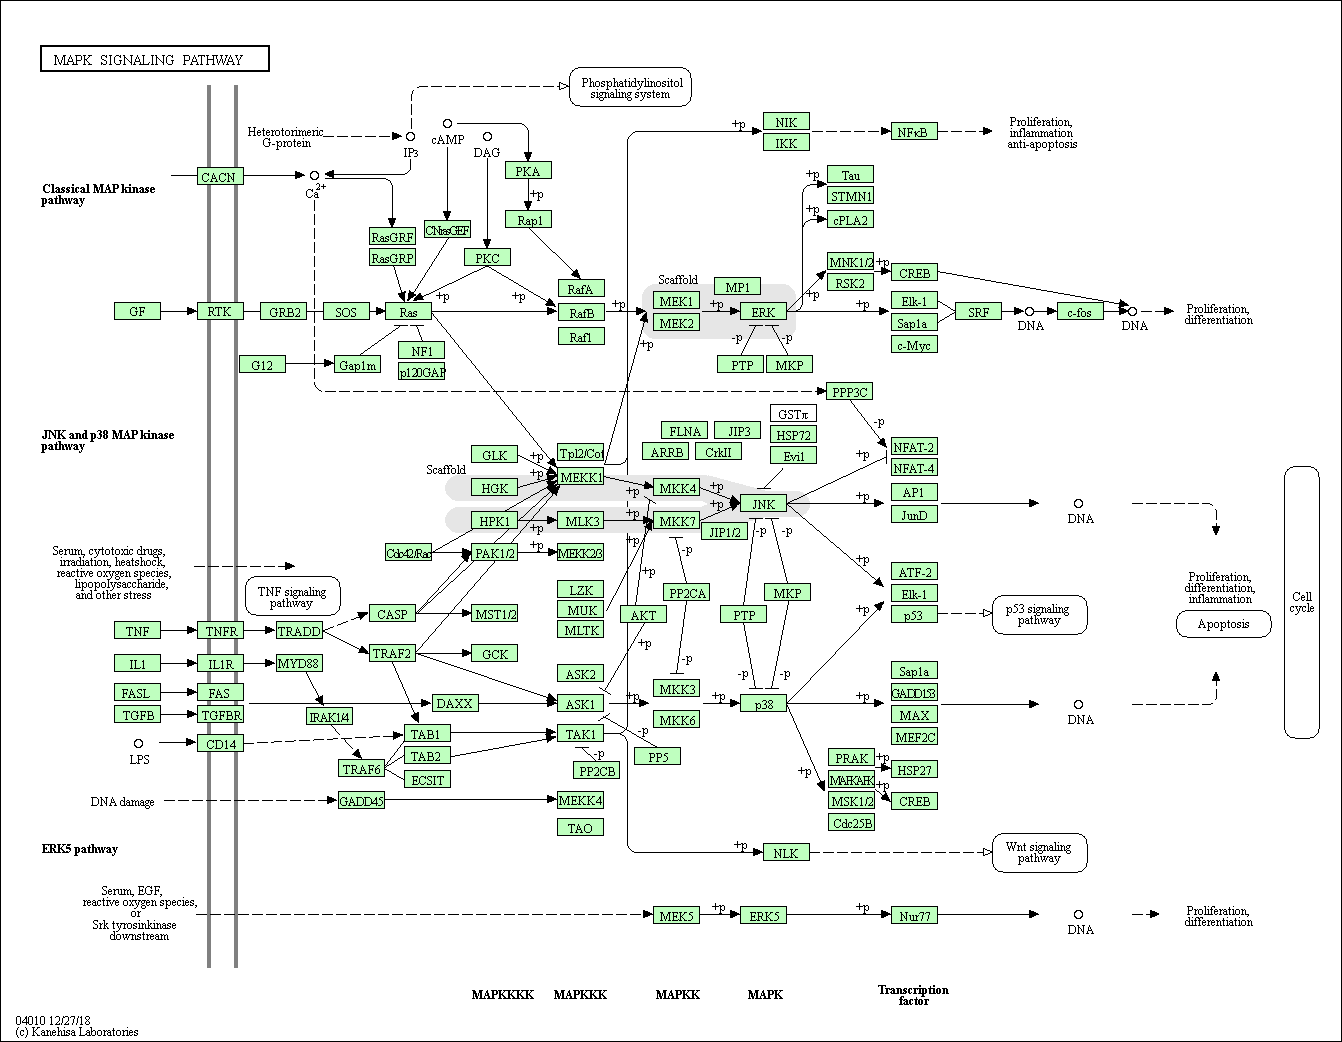

In [3]:
Image(kegg_get("mmu04010", "image").read())